# Inteligência Artificial - Trabalho
- Universidade Federal de Santa Catarina
- Departamento de Automação e Sistemas
- Prof. Eric Aislan Antonelo

### Grupo
-

### Opção: 1

#### 1. Implementação:
- Crie as estruturas de dados para guardar os pesos que definem uma arquitetura
de rede neural multi-camadas. Inicialize a rede neural aleatoriamente.
- Implemente o algoritmo da retropropagação para o cálculo do gradiente, a
derivada parcial da função de custo com relação aos pesos da rede.
- Valide o algoritmo do cálculo do gradiente, realizando uma aproximação numérica
do mesmo. Verifique se os cálculos batem um com o outro.
- Dado o gradiente já calculado, implemente o método do descenso do gradiente
para o treinamento da rede neural, ou seja, o processo de ajuste dos pesos.

#### 2. Aplicação:
- Use o código implementado para treinar uma rede neural para realizar a classificação de um padrão de duas dimensões de entrada. Os dados para treinamento
estão disponíveis no arquivo
classification2.txt.
Para plotar a fronteira de decisão da rede treinada, poderá usar o código
disponível no link
https://colab.research.google.com/drive/1XTtZGgpAefbiWejTrEjsnWzS_
XXYdzff?usp=sharing.
- Relate resultados variando pelo menos duas vezes cada um dos hiperparâmetros: o número de camadas; o número de neurônios por camada; taxa de aprendizagem. Use métricas como taxa de classificação (porcentagem de predições
corretas) no conjunto de validação (exemplos não usados no treinamento).
- (opcional) Treine uma rede neural para classificar dígitos a partir de imagens
como entrada para a rede. Use o arquivo
classification3.mat.

#### 3. Entregas:
No relatório a ser entregue, descreva os experimentos e os resultados obtidos.
Grave um video de até 3 minutos, onde você deve explicar o código implementado
de uma forma geral, as dificuldades encontradas, e em especial:
- a parte do código referente ao cálculo do gradiente
- a parte do código referente ao gradient descent
- o gráfico da fronteira de decisão
Entregue o código, PDF do relatório e o arquivo de video pelo Moodle (zipado com
ZIP ou tar.gz).

In [1]:
import pandas as pd
import numpy as np
import sys
import logging
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from numpy import genfromtxt

logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(message)s')

stdout_handler = logging.StreamHandler(sys.stdout)
stdout_handler.setFormatter(formatter)

logger.addHandler(stdout_handler)

### Data source

In [2]:
df = pd.read_csv('classification2.txt', header=None)
df.columns = ['column1', 'column2', 'label']
df.info()
print(f'\nLabel Value counts: \n{df.label.value_counts()}')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   column1  118 non-null    float64
 1   column2  118 non-null    float64
 2   label    118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB

Label Value counts: 
0    60
1    58
Name: label, dtype: int64


,column1,column2,label
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


### Correlation Matrix

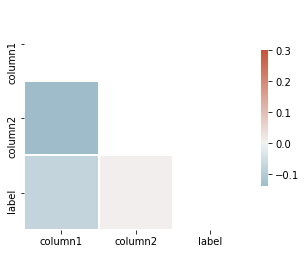

In [3]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr, mask=mask, cmap=cmap, vmax=.3, center=0,
    square=True, linewidths=.2, cbar_kws={"shrink": .5}
)
plt.show()

In [4]:
#X = df.iloc[:, :-1].to_numpy()
#y = df.iloc[:, -1]
#y = y.values.reshape(y.shape[0], 1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
X_train = genfromtxt('X_train.csv', delimiter=',')
X_test = genfromtxt('X_test.csv', delimiter=',')
y_train = genfromtxt('y_train.csv', delimiter=',')
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = genfromtxt('y_test.csv', delimiter=',')
y_test = y_test.reshape(y_test.shape[0], 1)

In [6]:
def print_metrics(y, preds):
    print(f'F1 : {f1_score(y, preds)}')
    print(f'Accuracy: {accuracy_score(y, preds)}')

### Neural net data structure

In [7]:
# To add bias
#self.input_length = input_length# + 1

#biased_input_data = np.ones((input_data.shape[0], input_data.shape[1] + 1))
#biased_input_data[:, :-1] = input_data

#next_activation = np.append(next_activation, 1)

#previous_deltas = new_deltas[:-1] # Exclude bias delta


In [8]:
def sigmoid(data):
    return 1 / (1 + np.exp(-data)) 

def sigmoid_derivative(data):
    return data * (1 - data)

def relu(Z):
    return np.maximum(0,Z)

def relu_derivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

class Neuron():
    def __init__(self, input_length):
        self.__weights = self.create_random_weights(input_length)
        
    def create_random_weights(self, input_length):
        return np.random.randn(input_length)
        
    @property
    def weights(self):
        return self.__weights
    
    @weights.setter
    def weights(self, new_value):
        self.__weights = new_value
    
    def __repr__(self):
        return f'Neuron {self.weights}'
    
class Layer():
    def __init__(self, input_length, n_neurons):
        self.input_length = input_length + 1 # input_length + bias_length
        self.n_neurons = n_neurons
        self.create_neurons()
        self.dd = np.zeros((self.n_neurons, self.input_length))
    
    def create_neurons(self):
        """Creates neurons of layer
        """
        self.neurons = list()
        for i in range(self.n_neurons):
            self.neurons.append(
                Neuron(self.input_length)
            )
            
    def __repr__(self):
        return f'Layer \n{self.weights_matrix}'
    
    @property
    def weights_matrix(self):
        """Represents layer's weights as a matrix, where each column is a neuron.
        """
        return np.array([n.weights for n in self.neurons])
    
    @weights_matrix.setter
    def weights_matrix(self, new_weights):
        for neuron_i, neuron in enumerate(self.neurons):
            neuron.weights = new_weights[neuron_i]
    
    def transform(self, input_data, activation_function):
        """Calculates layer output based on input data
        """
        
        # Include bias
        biased_input_data = np.ones((input_data.shape[0], input_data.shape[1] + 1))
        biased_input_data[:, :-1] = input_data
        #print('X')
        #print(input_data.shape)
        #print(input_data)
        #print('W')
        #print(self.weights_matrix.shape)
        #print(self.weights_matrix.T)
        self.z = np.dot(biased_input_data, self.weights_matrix.T)
        #print('Z')
        #print(self.z)
        #print('Activ func')
        #print(activation_function)
        self.activation = activation_function(self.z)
        #print('A')
        #print(self.activation)
        return self.activation

class NeuralNet():
    def __init__(self, *layers, learning_rate=0.1, epochs=5,
                 activation_function=sigmoid, der_activation_function=sigmoid_derivative):
        self.layers = layers
        self.learning_rate = learning_rate
        self.costs = list()
        self.epochs = epochs
        self.activation_function = activation_function
        self.der_activation_function = der_activation_function
    
    def transform(self, X):
        X_transformed = X.copy()
        for layer in self.layers[:-1]:
            X_transformed = layer.transform(X_transformed, activation_function=self.activation_function)

        X_transformed = self.layers[-1].transform(X_transformed, activation_function=sigmoid)
        return X_transformed.reshape(X.shape[0])
    
    def __repr__(self):
        return f'Neural Net \n{self.weights_matrix}'
    
    @property
    def weights_matrix(self):
        """Represents layer's weights as a matrix, where each column is a neuron.
        """
        return np.array([l.weights_matrix for l in self.layers], dtype=object)

    @weights_matrix.setter
    def weights_matrix(self, new_weights):
        for layer_i, layer in enumerate(self.layers):
            layer.weights_matrix = new_weights[layer_i]
    
    def cost_2(self, X, y):
        hx = self.transform(X)
        return 0.5 * np.sum((np.subtract(y.reshape(len(y)), hx) ** 2)) / X.shape[0]
            
    def cost(self, X, y):
        hx = self.transform(X)
        y_reshaped = y.reshape(len(y))
        
        log1_hx = np.log(hx)
        log2_hx = np.log(1 - hx)
        
        y_1 = y_reshaped * log1_hx
        y_0 = (1 - y_reshaped) * log2_hx

        return -np.sum(
            y_1 + y_0
        ) / X.shape[0]
    
    def has_next_item(self, list_, index_):
        return (index_ + 1) == len(list_)

    def backpropagate(self, sample, sample_i, hxi, label):
        logger.debug(f'\n\n+++++++++++++++')
        logger.debug(f'Starting backpropagration\n')
        logger.debug(f'Sample {sample}')
        logger.debug(f'Hxi {hxi}')
        logger.debug(f'Label {label}')
        
        reversed_layers = self.layers[::-1]
        previous_deltas = hxi - label
        
        logger.debug(f'Initial dds: \n{previous_deltas}\n')
        
        for layer_i, layer in enumerate(reversed_layers):
            logger.debug(f'\n-----------------')
            logger.debug(f'Index {layer_i}, {layer}\n')
            
            # Get activation from next layer
            if self.has_next_item(reversed_layers, layer_i):
                next_activation = sample
            else:
                next_layer = reversed_layers[layer_i + 1]
                next_activation = next_layer.activation[sample_i]
            
            # Add bias to activation
            next_activation = np.append(next_activation, 1)
            
            # Multiply weights with deltas
            transposed_weights = layer.weights_matrix.T
            
            logger.debug(f'Weights: \n{layer.weights_matrix}')
            logger.debug(f'Transposed weights: \n{transposed_weights}')
            logger.debug(f'Previous deltas: \n{previous_deltas}\n')

            weights_dot_delta = np.dot(transposed_weights, previous_deltas)
            logger.debug(f'Transposed Weights dot delta: \n{weights_dot_delta}')
            
            # Calculate activation function derivative
            der_act_function = self.der_activation_function(next_activation)
            logger.debug(f'Next layer activation: \n{next_activation}')
            logger.debug(f'Activation function derivative: \n{der_act_function}\n')
        
            # Calculate new deltas
            new_deltas = weights_dot_delta * der_act_function
            logger.debug(f'New deltas: \n{new_deltas}\n')
            
            # Calculate cost derivative
            dd = np.outer(previous_deltas, next_activation)
            layer.dd += dd
            previous_deltas = new_deltas[:-1] # Exclude bias delta
            logger.debug(f'Error derivative: \n{dd}')
            logger.debug(f'Layer error derivative: \n{layer.dd}')
            logger.debug('\n')
        
    def fit(self, X, y):
        logger.info(f'Fitting')
        cost_mse = list()
        for epoch in range(self.epochs):
            hx = self.transform(X)
            #logger.info(f'Running epoch {epoch}')
            for sample_i, sample in enumerate(X):
                #logger.info(f'\n\nBackProp')
                self.backpropagate(sample, sample_i, hx[sample_i], y[sample_i])

            for layer_i, layer in enumerate(self.layers):
                #logger.info(f'Layer {layer_i} {layer}')
                #logger.info(f'Error der \n{layer.dd}')
                #logger.info('')
                layer.weights_matrix -= self.learning_rate * layer.dd / len(X)
                
            self.costs.append(self.cost(X, y))
            cost_mse.append(self.cost_2(X, y))
        
        plt.plot(self.costs)
        plt.title('Cross entrophy cost')
        plt.ylabel('Cost')
        plt.xlabel('Epoch')
        plt.show()
        
        plt.plot(cost_mse)
        plt.title('Mean squared cost')
        plt.ylabel('Cost')
        plt.xlabel('Epoch')
        plt.show()

In [17]:
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)

layers = [
    Layer(input_length=X_train.shape[1], n_neurons=3),
    Layer(input_length=3, n_neurons=1),
]

np.random.seed(1) # Seed the random number generator
nn = NeuralNet(*layers, learning_rate=0.01, epochs=80,
              activation_function=relu, der_activation_function=relu_derivative)

#nn.weights_matrix = [
#    np.array(
#        [
#            [1.62434536, -1.07296862],
#            [-0.61175641, 0.86540763],
#            [-0.52817175, -2.3015387 ]
#        ],
#    ),
#    np.array([
#        [ 1.74481176, -0.7612069 ,  0.3190391]
#    ])
#]
print(nn)
#print(f'Initial cost: {nn.cost(X_train, y_train)}')

Neural Net 
[array([[ 1.62434536, -0.61175641, -0.52817175],
        [-1.07296862,  0.86540763, -2.3015387 ],
        [ 1.74481176, -0.7612069 ,  0.3190391 ]])
 array([[-0.24937038,  1.46210794, -2.06014071, -0.3224172 ]])]


Fitting


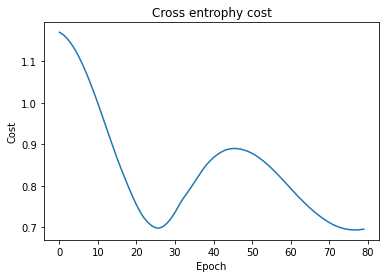

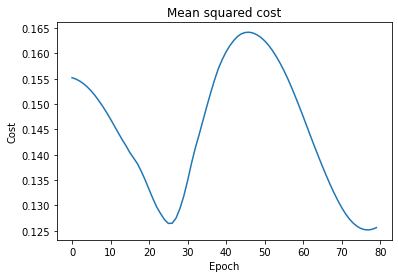

In [18]:
nn.fit(X_train, y_train)
nn_preds = nn.transform(X_test)
nn_preds_round = nn_preds.round()

In [19]:
print_metrics(y_test, nn_preds_round)
nn_preds_round

F1 : 0.0
Accuracy: 0.4722222222222222


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [ ]:
cls = LogisticRegression()
cls.fit(X_train, y_train)
lr_preds = cls.predict(X_test)
print('LogisticRegression')
print_metrics(y_test, lr_preds)

cls = MLPClassifier()
cls.fit(X_train, y_train)
mlp_preds = cls.predict(X_test)
print('MLPClassifier')
print_metrics(y_test, mlp_preds)

In [ ]:
def plot_outputs(X, y):
    plt.scatter(X[y==1,0],X[y==1,1],c="r",marker="+")
    plt.scatter(X[y==0,0],X[y==0,1],marker="o",s=10)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(["1","0"],loc=0)
    plt.show()
    
plot_outputs(X_test, y_test.reshape((len(y_test))))
plot_outputs(X_test, nn_preds_round)

In [ ]:
# add header names
headers =  ['age', 'sex','chest_pain','resting_blood_pressure',  
        'serum_cholestoral', 'fasting_blood_sugar', 'resting_ecg_results',
        'max_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak',"slope of the peak",
        'num_of_major_vessels','thal', 'heart_disease']

heart_df = pd.read_csv('heart.csv', names=headers, skiprows=range(1))

X = heart_df.iloc[:, :-1]
y = heart_df.iloc[:, -1].values.reshape(X.shape[0], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(f"Shape of train set is {X_train.shape}")
print(f"Shape of test set is {X_test.shape}")
print(f"Shape of train label is {y_train.shape}")
print(f"Shape of test labels is {y_test.shape}")

In [ ]:
###############
##### Plotando fronteira de decisão não-linear
###############

import numpy as np
import matplotlib.pyplot as plt

# Plotando fronteira de decisão
x1s = np.linspace(-1,1.5,50)
x2s = np.linspace(-1,1.5,50)
z = np.zeros((len(x1s),len(x2s)))

z = theta.T * x

for i in range(len(x1s)):
    for j in range(len(x2s)):
        z[i,j] =  # saida do modelo antes de aplicar a função sigmoide 
plt.contour(x1s,x2s,z.T,0)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc=0)